In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from collections import deque
from itertools import cycle
import math

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, namedtuple

In [2]:
InOut = namedtuple('InOut', ['x', 'y'])
TrainDev = namedtuple('TrainDev', ['train', 'dev'])

## Dataset key

In [3]:
feature_key = {                                                      
    'zanr':  ['zpravodajství', 'rozhovor', 'komentář'],                       
    'tema': ['migrační krize', 'domácí politika',                             
        'zahraniční politika / diplomacie',                                   
        'společnost / společenská situace', 'jiné', 'energetika',             
        'sociální politika', 'konflikt na Ukrajině', 'kultura',               
        'konflikt v Sýrii', 'zbrojní politika', 'ekonomika / finance',        
        'konspirace'],                                                        
    'zamereni': ['zahraniční', 'domácí', 'obojí', 'nelze určit'],             
    'lokace': ['EU', 'Česká republika', 'USA', 'jiná země',                   
        'jiné / nelze určit', 'Rusko', 'NATO', 'Rusko + USA'],                
    'argumentace': ['ne', 'ano'],                                             
    'emoce': ['missing', 'rozhořčení', 'soucit', 'strach', 'nenávist', 'jiná'],
    'vyzneni_celku': ['neutrální', 'negativní', 'pozitivní'],                 
    'rusko': ['missing', 'pozitivní příklad', 'neutrální', 'oběť',            
        'negativní příklad', 'hrdina'],                                       
    'vyzneni1': 
        ['neutrální', 'negativní', 'missing', 'pozitivní', 'velebící', 'nenávistné'],                                                        
    'vyzneni2':
        ['neutrální', 'negativní', 'missing', 'pozitivní', 'velebící', 'nenávistné'],                                                        
    'vyzneni3':
        ['neutrální', 'negativní', 'missing', 'pozitivní', 'velebící', 'nenávistné'],                                                        
    'obrazek': ['ne', 'ano'],                                                 
    'video': ['ne', 'ano'],                                                   
    'nazor': ['ne', 'ano'],                                                   
    'odbornik': ['ne', 'ano'],                                                
    'zdroj': ['ne', 'ano'],                                                   
    'strach': ['ne', 'ano'],                                                  
    'vina': ['ne', 'ano'],                                                    
    'nalepkovani': ['ne', 'ano'],                                             
    'demonizace': ['ne', 'ano'],                                              
    'relativizace': ['ne', 'ano'],                                                                                                                           
    'fabulace': ['ne', 'ano'],                                                
    'year': ['2016', '2017', '2018']
}

## Load dataset 

In [4]:
def get_dataset(path):
    df = pd.read_csv("dataset/data_raw.csv")
    df.tema[df.tema == "sociálni politika"] = "sociální politika"
    df.head()
    
    x_column = "text"
    
    x = df[x_column]
    
    ydf = pd.DataFrame()
    for column in df.loc[:, df.columns != x_column]:
        ydf[column] = df[column].map(lambda x: feature_key[column].index(x))
    y = {col: ydf[col].to_numpy() for col in ydf}
    
    return InOut(x, y)

dataset = get_dataset("dataset/data_raw.csv")

## Czech ALBERT model definitions 

In [5]:
model_defs = {
    # example: (path, width, batch_size)
    "csbase3": ("pretrained/csbase3_ckpt/", 256, 24),
    "csbase4": ("pretrained/csbase4_ckpt/", 256, 16),
    "cslarge3": ("pretrained/cslarge3_ckpt/", 512, 12)
}

## Tokenization 

In [6]:
import sentencepiece as spm

class SPMEmbedder():
    def __init__(self, path):
        sp = spm.SentencePieceProcessor()
        sp.Load(path)
        self.sp = sp
        
    def encode(self, text):
        return [self.sp.piece_to_id("[CLS]"),
                *self.sp.EncodeAsIds(text), 
                self.sp.piece_to_id("[SEP]")
               ]
    
    def decode(self, indexes):
        return self.sp.DecodeIds(list(map(int, indexes)))
    
    def decode_pieces(self, indexes):
        return " ".join(self.sp.id_to_piece(int(id_)) for id_ in indexes)
    
    def get_embed_fcn(self, width):
        def embed(sentence):
            return pad_sequences([self.encode(sentence)], width,
                                 padding="post", truncating="post")[0]
        return embed 


In [7]:
def lemmatize(text):
    text = text.lower()
    text = re.sub("[0-9]", "#", text)
    text = re.sub("[‒–—―]", "-", text)
    text = re.sub("[“”‘’„“‚‘\"']", "'", text)
    text = re.sub("[^0-9a-zóěščřžýáíďéťňůúA-ZÓĚŠČŘŽÝÁÍĎÉŤŇŮÚ\\.,\\!\\?%\\(\\)\\-'#: ]", "", text)

    return text


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
RANDOM_STATE = 42

def get_training_data(dataset, width, task, verbose=False):
    x, y = dataset.x, dataset.y[task]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    
    train_index, test_index = next(sss.split(x, y))
    train = InOut(x[train_index], y[train_index])
    dev = InOut(x[test_index], y[test_index])

    return TrainDev(train, dev)


## ALBERT model creation

In [9]:
import tensorflow as tf
from tensorflow import keras as keras
import bert

from pprint import pprint
from IPython.utils import io
from IPython.display import HTML
import matplotlib.pyplot as plt


def get_albert_layer(path, max_seq_len, name, trainable=True):
    albert_params = bert.albert_params(path)
    l_albert = bert.BertModelLayer.from_params(albert_params, name=name, 
                                             shared_layer=True, trainable=trainable)
    return l_albert
    
def get_auto_model(path, max_seq_len, feature_key, task, name, albert_trainable=True, init=True):
    l_input_ids = keras.layers.Input(shape=(max_seq_len,), dtype='int32', name="input_tokens")
    l_albert = get_albert_layer(path, max_seq_len, "albert", albert_trainable)
    l_middle = l_albert(l_input_ids)
    cls_embed = keras.layers.Lambda(lambda seq: seq[:, 0, :], name="cls_selector")(l_middle)
    
    num_classes = len(feature_key[task])
    taskname = task
    l_output = keras.layers.Dense(num_classes, activation='softmax', name=taskname)(cls_embed)

    
    model = keras.Model(inputs=l_input_ids, outputs=l_output, name=name)
    opt = keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

    if init:
        with io.capture_output() as captured:
            bert.load_albert_weights(l_albert, path+"model.ckpt-best")
            notfound = re.search(r"Count of weights not found in the checkpoint was: \[([0-9]*)\].",
                                 captured.stdout
                                ).groups(1)[0]

        print("Weights loaded.", notfound, "not found.\n")
    else:
        print("Skipping weight loading.")

    return model

## Callback for evaluation during training 

In [10]:
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score

class BatchCB(tf.keras.callbacks.Callback):
    def __init__(self, dev_set):
        self.logs = []
        self.devset = dev_set
        
    def on_epoch_end(self, batch, logs=None):        
        predictions = self.model.predict(self.devset.x)
        pred_labels = np.argmax(predictions, axis=1)
        acc = accuracy_score(self.devset.y, pred_labels)
        bal_acc = balanced_accuracy_score(self.devset.y, pred_labels)
        wf1 = f1_score(self.devset.y, pred_labels, average="weighted")

        print(f"{' '*10} || {acc=:.3f} | {bal_acc=:.3f} | {wf1=:.3f} ", end="")
        
        logs = dict(logs)
        logs["val_acc"] = acc
        logs["val_bal_acc"] = bal_acc
        logs["val_wf1"] = wf1
        
        self.logs.append(logs)
        

## Evaluation process

In [21]:
def get_class_weights(y):
    y = pd.Series(y)
    return (len(y)/y.value_counts()/len(y.value_counts()))


def eval_model(model_name, dataset, tasks, dataset_name="prop", init=True, verbose=False):
    model_path, max_seq_len, batch_size = model_defs[model_name]
    
    print(f"Tokenizing for {model_name}, width: {max_seq_len} ...", end="", flush=True)
    x = dataset.x
    embedder = SPMEmbedder(f"{model_path}/spm.model")
    x = np.stack(x.map(lemmatize).map(embedder.get_embed_fcn(max_seq_len)))
    dataset = InOut(x, dataset.y)
    print(" Done")
    
    for task in tasks:
        
        display(HTML(f"<h1 style=\"color: blue\">{task}</h1>"))
        train, dev = get_training_data(dataset, max_seq_len, task, verbose=verbose)
        class_coefs = get_class_weights(train.y)
        
        model = get_auto_model(model_path,
                               max_seq_len,
                               feature_key,
                               task,
                               f"{dataset_name}_{model_name}_{task}",
                               albert_trainable=True,
                               init=init
        )
        
        print()
        model.summary()
        
        last_epoch = 0
        cur_coefs = {k: v for k, v in class_coefs.items()}
        epochs_per_loop = 1
        bcb = BatchCB(dev)
        
        for _ in range(6):
            model.fit(
                train.x,
                train.y,
                class_weight=cur_coefs,
                batch_size=batch_size,
                epochs=last_epoch+epochs_per_loop,
                initial_epoch=last_epoch,
                callbacks=[
                    bcb,
                ]
            )

            last_epoch += epochs_per_loop
            cur_coefs = {k: v**0.7 for k, v in cur_coefs.items()}
            
        results = pd.DataFrame({
            "train_acc": [x["acc"] for x in bcb.logs],
            "val_acc": [x["val_acc"] for x in bcb.logs],
            "val_bal_acc": [x["val_bal_acc"] for x in bcb.logs],
            "val_wf1": [x["val_wf1"] for x in bcb.logs],                                
        })
        
        vf1 = results.val_wf1.max()
        vacc = results.val_acc.max()
        
        plot = results.plot(figsize=(7,4), title=f"{task} - {vacc:.3f} | {vf1:.3f}")
        plt.show()
            
        

## Running evaluation

Tokenizing for csbase3, width: 256 ... Done


Weights loaded. 0 not found.


Model: "prop_csbase3_argumentace"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tokens (InputLayer)    [(None, 256)]             0         
_________________________________________________________________
albert (BertModelLayer)      (None, 256, 256)          5221120   
_________________________________________________________________
cls_selector (Lambda)        (None, 256)               0         
_________________________________________________________________
argumentace (Dense)          (None, 2)                 514       
Total params: 5,221,634
Trainable params: 5,221,634
Non-trainable params: 0
_________________________________________________________________
289/289 [==============================] - 144s 497ms/step - loss: 0.6611 - acc: 0.6371   || acc=0.677 | bal_acc=0.646 | wf1=0.662
Epoch 2/2
289/289 [==============================] - 142s 493ms/step

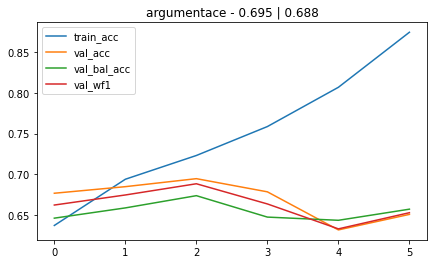

Weights loaded. 0 not found.


Model: "prop_csbase3_lokace"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tokens (InputLayer)    [(None, 256)]             0         
_________________________________________________________________
albert (BertModelLayer)      (None, 256, 256)          5221120   
_________________________________________________________________
cls_selector (Lambda)        (None, 256)               0         
_________________________________________________________________
lokace (Dense)               (None, 8)                 2056      
Total params: 5,223,176
Trainable params: 5,223,176
Non-trainable params: 0
_________________________________________________________________
289/289 [==============================] - 144s 497ms/step - loss: 1.9587 - acc: 0.3143   || acc=0.448 | bal_acc=0.426 | wf1=0.422
Epoch 2/2
289/289 [==============================] - 142s 490ms/step - lo

In [ ]:
eval_model("csbase3", dataset, [
    "argumentace", 
    "lokace", 
    "zdroj", 
    "rusko", 
    "odbornik", 
    "tema", 
    "zamereni", 
], init=True)